## Step 1: Creating a genus-0 reference surface, $S_{ref}(x,y,z)$ using conformalized mean curvature flow 

To create a genus-0 reference surface we run conformalized mean curvature flow (cMCF) on an input surface, $S(x,y,z)$. We monitor the discrete Gaussian curvature and choose a surface near the inflexion point where the high curvature surface protrusions is smoothed out and the flow begins to deform the smooth cell cortex. There is no strict requirement on the input surface e.g. can be genus-X and need not be watertight or closed. However cMCF may terminate early if the input mesh is particularly bad. 

We are working on mesh surgery and repair methods to in future guarantee the ability to run cMCF and produce a genus-0 surface. 

### Load cell surface mesh and create an analysis save folder

We assume the user has worked through step 0 which generates and saves a cell surface mesh to the folder `example_results/bleb_example/step0_cell_segmentation`. Moreover this cell surface has been colored by curvature or molecular intensity. 

In [1]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio

# example cell used
imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step1_cMCF_reference')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


# load the pre-generated cell surface mesh for the cell
cell_surface_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
cell_surface_file = os.path.join(cell_surface_folder, 
                                'curvature_binary_mesh_%s.obj' %(basefname)) 
mesh = meshtools.read_mesh(cell_surface_file)


# also load the molecular signal (PI3K) colored cell surface mesh for the cell for added visualization
cell_surface_file_PI3K = os.path.join(cell_surface_folder, 
                                'PI3K_binary_mesh_%s.obj' %(basefname)) 
PI3K_mesh = meshtools.read_mesh(cell_surface_file_PI3K)


C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\fyz11\anaconda3\envs\unwrap3D\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


### Conformalized mean curvature flow (cMCF)

Conformalized mean curvature flow (cMCF) is a simple variant of mean curvature flow proposed by [Kazhdan et al.](https://arxiv.org/abs/1203.6819) which iteratively smooth high curvature mesh features with the sphere as the convergence limit. We use it as part of u-Unwrap3D to both smoothen high curvature surface protrusions into the cell cortex as well as to close holes and handles in the input surface, $S(x,y,z)$ so we can generate an intermediary surface that can be repaired/remeshed to obtain a genus-0 reference, $S_{ref}(x,y,z)$.   

The flow is computed using the cotangent Laplacian. If input surface has non-manifold vertices/edges, small angles etc. the user can also try running with the robust Laplacian proposed by [Sharpe et al.](https://www.cs.cmu.edu/~kmcrane/Projects/NonmanifoldLaplace/NonmanifoldLaplace.pdf) by setting the appropriate input flag.

In [2]:
# run cMCF on the mesh for 50 iterations, delta=5e-4 using the standard cotangent Laplacian 
Usteps_MCF, mesh_F, MCF_measures_dict = meshtools.conformalized_mean_curvature_flow(mesh, 
                                                                                    max_iter=50, 
                                                                                    delta=5e-4, 
                                                                                    conformalize=True, # set this flag to run cMCF, else it will run MCF
                                                                                    robust_L =False, # if set, runs MCF/cMCF using the robust Laplacian instead of cotangent Laplacian
                                                                                    mollify_factor=1e-5)  # this is a parameter used in the robust Laplacian

# cMCF is run as a free-form deformation, if we want to have the mesh represent a gradual smoothing in accordance with the physical size of the cell and the image coordinates we need to put back the correct scaling factors.
Usteps_MCF_img = meshtools.recover_img_coordinate_conformal_mean_flow(Usteps_MCF, MCF_measures_dict) # recovers the proper associated image coordinates 
    

    
"""
Save the output
"""
# save the vertex positions with face connectivity
spio.savemat(os.path.join(savefolder, 
                          'MCF_iterations_'+basefname+'.mat'), 
              {'v': Usteps_MCF, # freeform coordinates
               'v_img': Usteps_MCF_img,  # rescaled image coordinates
               'f': mesh_F}) # face connectivity

# save the convergence measures. We computed several but found the absolute Gaussian curvature to be most useful and well behaved.
spio.savemat(os.path.join(savefolder, 
                          'MCF_convergence_measures_'+basefname +'.mat'),
                           MCF_measures_dict) 


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:40<00:00, 15.22s/it]


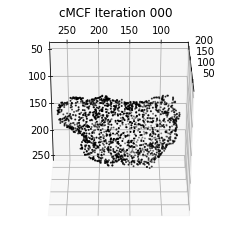

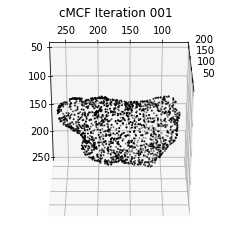

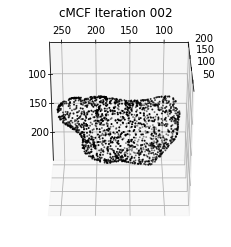

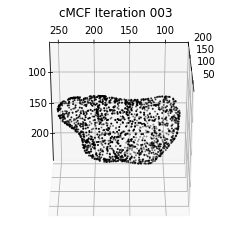

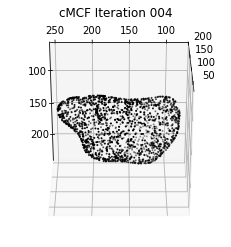

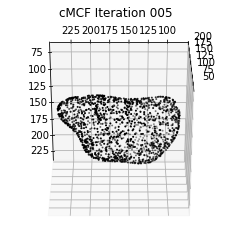

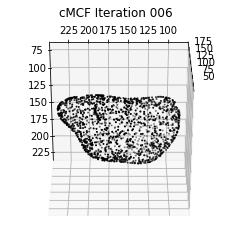

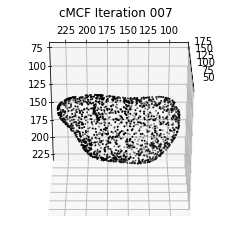

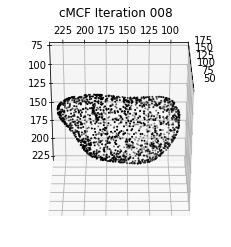

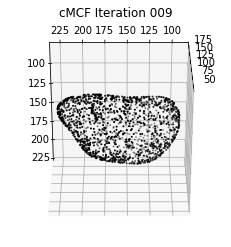

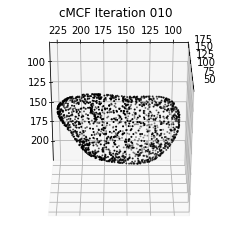

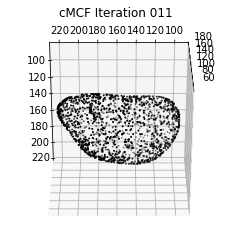

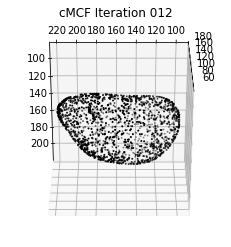

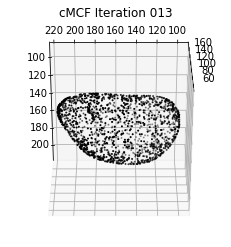

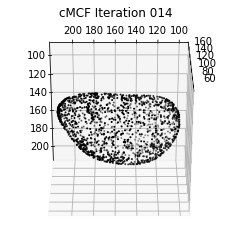

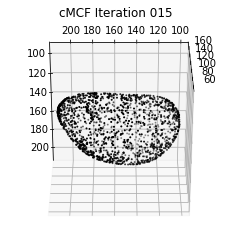

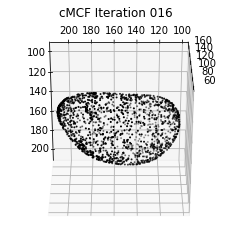

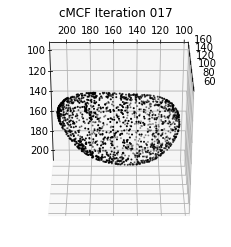

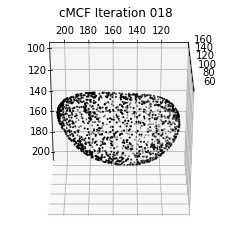

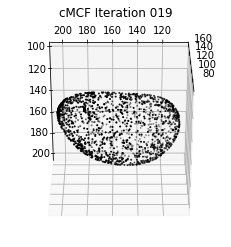

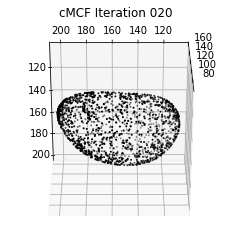

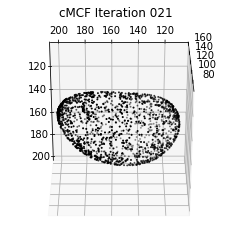

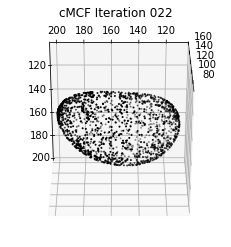

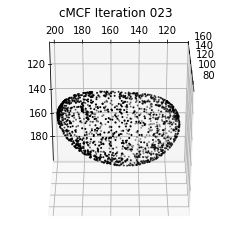

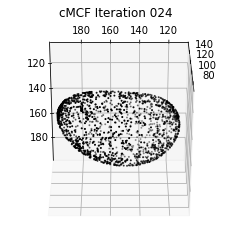

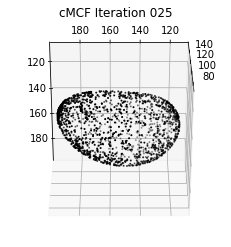

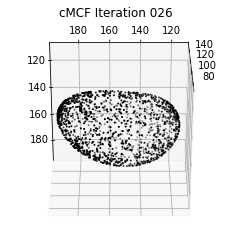

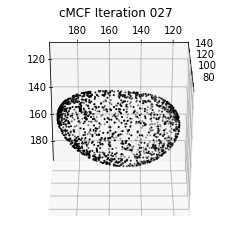

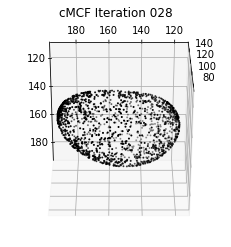

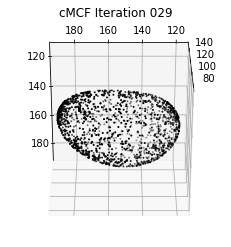

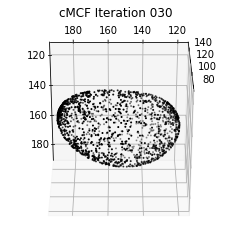

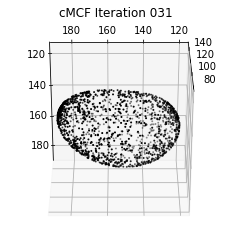

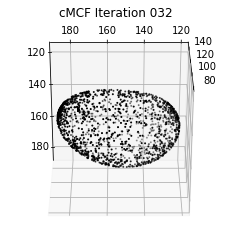

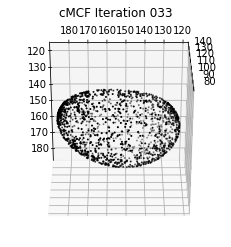

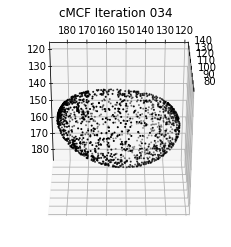

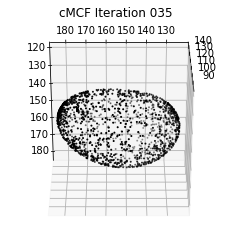

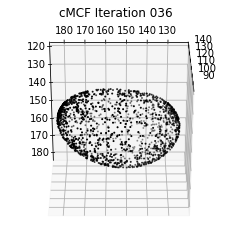

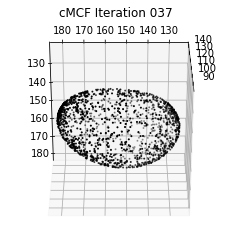

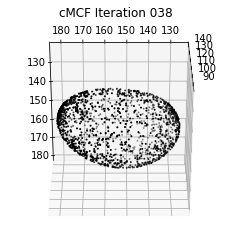

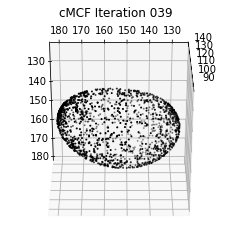

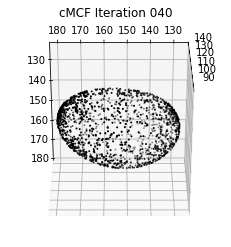

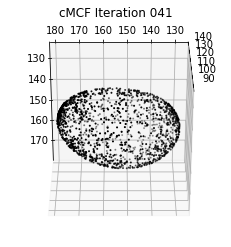

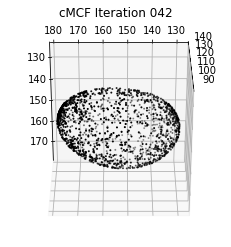

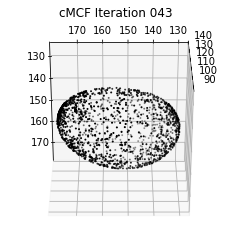

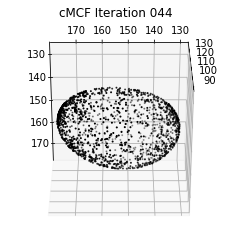

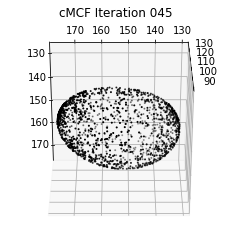

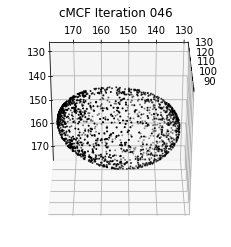

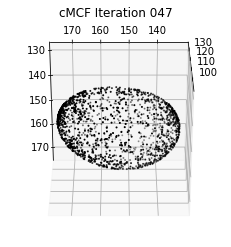

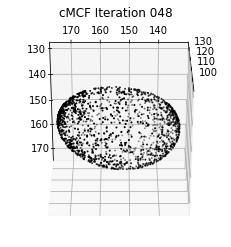

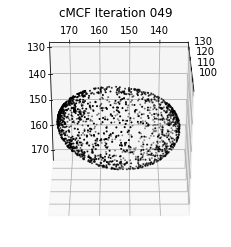

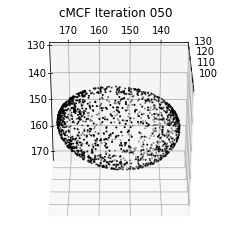

In [3]:
"""
Optional saving of intermediate surfaces during the flow
"""
import unwrap3D.Visualisation.plotting as plotting
import pylab as plt 

# cMCF does not change the mesh face topology, the output is thus an array of vertex positions corresponding to each iteration of flow.
# optionally we can save each iteration to meshes that can be loaded into e.g. meshlab and snapshotted to make a movie
# to do this uncomment the following lines. 

save_MCF_folder = os.path.join(savefolder, 'cMCF_flow_curvature'); fio.mkdir(save_MCF_folder)

# iterate over the cMCF iterations.
for ii in np.arange(Usteps_MCF.shape[-1])[:]:
    
    # Curvature mesh
    MCF_mesh = meshtools.create_mesh(vertices=Usteps_MCF_img[...,ii], 
                                    faces=mesh_F, 
                                    vertex_colors=mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh.export(os.path.join(save_MCF_folder, 'curvature_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    # PI3K mesh
    MCF_mesh_PI3K = meshtools.create_mesh(vertices=Usteps_MCF_img[...,ii], 
                                        faces=mesh_F, 
                                        vertex_colors=PI3K_mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh_PI3K.export(os.path.join(save_MCF_folder, 'PI3K_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    
    # also take a look through matplotlib 
    sampling = 100 # plot every just so its not fully dense in the plot so we don't see anything!

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    plt.title('cMCF Iteration '+str(ii).zfill(3))
    ax.scatter(MCF_mesh.vertices[::sampling,2], 
               MCF_mesh.vertices[::sampling,1],
               MCF_mesh.vertices[::sampling,0], 
               s=1, 
               c='k')
    ax.view_init(-60, 180)
    plotting.set_axes_equal(ax)
    plt.show()

### Automatic reference surface determination with Gaussian curvature

We monitor the decay in absolute Gaussian curvature to determine the surface at which iteration number of cMCF should be used as a reference. In particular we would like to select a surface which is close in shape to the input $S(x,y,z)$ but with surface protrusions smoothed out. We thus try to seek out the first inflexion point in the decay curve. This is done by thresholding on the rate of change.  

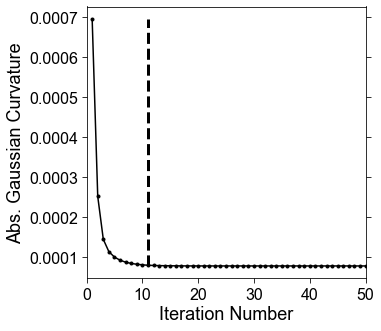

In [4]:
# load the mean absolute Gaussian curvature at vertices at each iteration of the cMCF
gauss_curve_MCF = MCF_measures_dict['gauss_curvature_iter'].copy()


threshold_cMCF = 5e-7
# determine the cut off iteration number such that the change between the previous iteration drops below 5e-7
ind = meshtools.find_curvature_cutoff_index( gauss_curve_MCF, 
                                              thresh=threshold_cMCF,  # cutoff on the rate of change.
                                              absval=True) 

# add the determined index to the MCF_measures_dict and resave. 
MCF_measures_dict['cMCF_ind'] = ind
MCF_measures_dict['threshold_cMCF'] = threshold_cMCF
spio.savemat(os.path.join(savefolder, 
                          'MCF_convergence_measures_'+basefname +'.mat'),
                           MCF_measures_dict)

"""
plot the evolution of the curve and mark the chosen iteration number
"""
import pylab as plt 

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.arange(1,len(gauss_curve_MCF)+1), 
          gauss_curve_MCF, '.-', color='k')
plt.vlines(ind, 
            np.min(gauss_curve_MCF), 
            np.max(gauss_curve_MCF), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,50])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Abs. Gaussian Curvature', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder, 
                          'MCF_iterations_'+basefname.replace('.tif', '.svg')), bbox_inches='tight')
plt.show()
    

### Quantifying conformal and equiareal distortion errors during cMCF

We can measure the conformal and equiareal distortion error at each cMCF iteration relative to the initial surface $S(x,y,z)$. This is somewhat slow. 

In [5]:
conformal_error_flow = [meshtools.quasi_conformal_error(Usteps_MCF_img[...,0], Usteps_MCF_img[...,steps], mesh.faces) for steps in np.arange(Usteps_MCF_img.shape[-1])]
area_distortion_error_flow = [meshtools.area_distortion_measure(Usteps_MCF_img[...,0], Usteps_MCF_img[...,steps], mesh.faces) for steps in np.arange(Usteps_MCF_img.shape[-1])]

# figure out how to save out these information.
conformal_error_flow_arrays = [ np.array([cc[jj] for cc in conformal_error_flow]) for jj in np.arange(len(conformal_error_flow[0]))]
area_distortion_error_flow = np.array(area_distortion_error_flow) 

spio.savemat(os.path.join(savefolder, 
                          'MCF_conformal_area_errors.mat'), 
                          {'conformal_Jac_eigvals': conformal_error_flow_arrays[0], 
                          'conformal_stretch_factors': conformal_error_flow_arrays[1], # this is the per face conformal error. 
                          'mean_conformal_stretch_factors': conformal_error_flow_arrays[2], # this is the mean conformal error at each iteration
                          'conformal_tri_area_pairs': conformal_error_flow_arrays[3], 
                          'conformal_area_distortion_factor': area_distortion_error_flow}) # this is the per face equiareal error. 
    

We can now plot the mean conformal and equiareal distortion errors as a function of the cMCF iteration number.

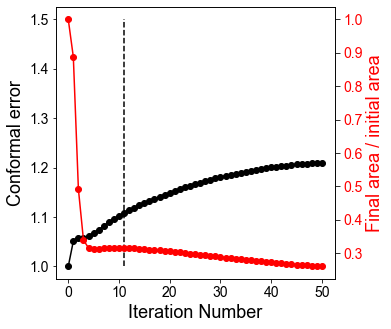

In [6]:
mean_conformal_error_curve = conformal_error_flow_arrays[2].copy()
mean_area_errors_curve = area_distortion_error_flow.mean(axis=1).copy()

# plot the errors as a function of iteration number 
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.set_xlabel('Iteration Number', fontsize=18, fontname='Arial')
ax1.set_ylabel('Conformal error', fontsize=18, fontname='Arial', color='k')
ax1.plot(np.arange(len(mean_conformal_error_curve)), mean_conformal_error_curve, 'ko-')
ax1.vlines(ind,1,1.5, linestyles='dashed', color='k')
ax1.tick_params(axis='y', labelcolor='k')
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Final area / initial area', fontsize=18, color='r', fontname='Arial')  # we already handled the x-label with ax1
ax2.plot(np.arange(len(mean_area_errors_curve)), 1./mean_area_errors_curve, 'ro-')
ax2.tick_params(axis='y', labelcolor='r')
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)
plt.tick_params(length=5)
plt.savefig(os.path.join(savefolder,  
                       'mean_MCF_errors_iterations_'+basefname+'.png'), bbox_inches='tight', dpi=300)
plt.show()

### Quantifying and colormapping the conformal and equiareal distortion error of $S_{ref}(x,y,z)$ 

In [7]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

"""
conformal error
"""
conformal_error = meshtools.quasi_conformal_error(Usteps_MCF_img[...,0], 
                                                  Usteps_MCF_img[...,ind], 
                                                  mesh.faces)
# color mapping S(x,y,z) using a 1-1.5 scale in jet.
conformal_error_colors = vol_colors.get_colors(conformal_error[1], colormap=cm.jet, vmin=1., vmax=1.5)

img_binary_conformal_colors = meshtools.create_mesh(vertices=Usteps_MCF_img[...,0],
                                                  faces=mesh.faces,
                                                  face_colors=np.uint8(255*conformal_error_colors[:,:3])) # note we set the face_colors 
tmp = img_binary_conformal_colors.export(os.path.join(savefolder,
                                                'curvature_cMCF_conformal_error.obj'))
# also color the cMCF shape. 
img_binary_conformal_colors.vertices = Usteps_MCF_img[...,ind].copy()
tmp = img_binary_conformal_colors.export(os.path.join(savefolder, 
                                           'curvature_cMCF_conformal_error_Sref.obj'))
"""
equiareal distortion error
"""
area_distortion_error = meshtools.area_distortion_measure(Usteps_MCF_img[...,0], # original
                                                          Usteps_MCF_img[...,ind], # cMCF
                                                          mesh.faces)
# color mapping S(x,y,z) the -log(area fraction) using a -3 to 3 scale in reverse coolwarm so that negative means the original surface has been compressed whilst a positive value means the original surface has been expanded.
area_distortion_error_colors = vol_colors.get_colors(-np.log(area_distortion_error), 
                                                      colormap=cm.coolwarm_r, 
                                                      vmin=-3, vmax=3)

img_binary_area_colors = meshtools.create_mesh(vertices=Usteps_MCF_img[...,0],
                                              faces=mesh.faces,
                                              face_colors=np.uint(255*area_distortion_error_colors[:,:3])) 
tmp = img_binary_area_colors.export(os.path.join(savefolder, 
                                           'curvature_MCF_paper_area_error.obj'))

# also color the cMCF shape. 
img_binary_area_colors.vertices = Usteps_MCF_img[...,ind].copy()
tmp = img_binary_area_colors.export(os.path.join(savefolder, 
                                           'curvature_MCF_paper_area_error_Sref.obj'))


### Remeshing $S_{ref}(x,y,z)$ to be genus-0 using voxelization

We demonstrate how to voxelize the mesh i.e. convert it to a binary volume image to take advantage of binary morphological operations to close small holes and handles and then conduct a meshing of the fixed binary volume to get a genus-0 $S_{ref}(x,y,z)$.

**NOTE**: In this example, we don't actually need to voxelize and remesh to get a genus-0 shape. This is because the original mesh was both already genus-0 and has been isotropically remeshed. An isotropic remesh is important since it means we can do area distortion relaxation later. 

In [8]:
# first explicitly make a mesh of the intermediate S_ref(x,y,z) obtained direct from cMCF.  
cMCF_Sref = meshtools.create_mesh(vertices = Usteps_MCF_img[...,ind],  
                                    faces = mesh.faces,
                                    vertex_colors=mesh.visual.vertex_colors)

save_smooth_mesh_file = os.path.join(savefolder, 
                                     'unwrap_cMCF_smooth_mesh.obj')
tmp = cMCF_Sref.export(save_smooth_mesh_file)


"""
Voxelization of mesh 
"""
# vol_shape allows us when available to use the volume grid size of the original image. -> the advantage is that no postcorrection is required to maintain image coordinates.
# If not available the maximum extent of the vertices are used to determine a bounding box which is then padded
smooth_img_binary = meshtools.voxelize_image_mesh_pts(cMCF_Sref, # might be best here to use barycenter 
                                                      pad=50, 
                                                      dilate_ksize=5, # this is the size of the ball kernel to plug holes and handles. 
                                                      erode_ksize=5, # this undoes the dilation to keep the remesh close to the original surface.
                                                      vol_shape=None) # erode to make smaller.

"""
remesh at isovalue of 0.5
"""
cMCF_Sref_remesh = meshtools.marching_cubes_mesh_binary(smooth_img_binary, 
                                                            presmooth=1., 
                                                            contourlevel=.5, 
                                                            remesh=True, 
                                                            remesh_method='pyacvd', 
                                                            remesh_samples=0.1, # lower downsampling will give a smoother mesh, see below on voxelization artifacts.
                                                            predecimate=True, 
                                                            min_mesh_size=60000)  

save_smooth_remesh_file = os.path.join(savefolder, 
                                     'unwrap_cMCF_Sref_mesh.obj')
tmp = cMCF_Sref_remesh.export(save_smooth_remesh_file)


# check this remesh gives a genus-0 mesh
mesh_property = meshtools.measure_props_trimesh(cMCF_Sref_remesh, main_component=True, clean=True) 
print(mesh_property)


E:\Work\Projects\Danuser-3D Causality\Code\unwrap3D\unwrap3D\Mesh\meshtools.py:448: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  V, F, _, _ = marching_cubes_lewiner(img, level=contourlevel, allow_degenerate=False)


{'convex': False, 'volume': True, 'watertight': True, 'orientability': True, 'euler_number': 2, 'genus': 0.0}


In [9]:
"""
optional additional smoothing to remove voxelization 'aliasing' artifacts. [SLOW]
"""
# one issue with voxelizing onto a discrete voxel grid is that smoothness is lost and the surface becomes 'blocky'. 
# This is partially mitigated above by isotropic remeshing to a lower fraction of the number of vertices of the initial Marching Cubes mesh.
# A more effective method is to use Laplacian smoothing with volume constraint

from trimesh.smoothing import filter_laplacian, laplacian_calculation

# this function filters the mesh in-place so we first make a copy.
cMCF_Sref_remesh_lap_smooth = cMCF_Sref_remesh.copy()
cMCF_Sref_remesh_lap_smooth = filter_laplacian(cMCF_Sref_remesh_lap_smooth,
                                              lamb=0.5, # keep this small, else the coordinates shift
                                              iterations=15, # beyond this, seems to give coordinate shift
                                              implicit_time_integration=True,
                                              volume_constraint=True, 
                                              laplacian_operator=laplacian_calculation(cMCF_Sref_remesh, equal_weight=False)) # this is required to set the cotangent laplacian.

save_smooth_remesh_lap_file = os.path.join(savefolder, 
                                     'unwrap_cMCF_Sref_mesh_lap-smooth_15iter.obj')
tmp = cMCF_Sref_remesh_lap_smooth.export(save_smooth_remesh_lap_file)


### Quantifying the geometric similarity between the intermediary cMCF and the remeshed $S_{ref}(x,y,z)$

The remeshing changes the parameterization of the two surfaces i.e. the particular mesh coordinates, but should not change the bijectivity of the surfaces i.e. they map to the same underlying shape.

To check: 
1. we can plot the vertices of the original and remeshed surface to check geometric similarity. 
2. We can also compute several quantitative metrics to check the geometric similarity to the original surface.

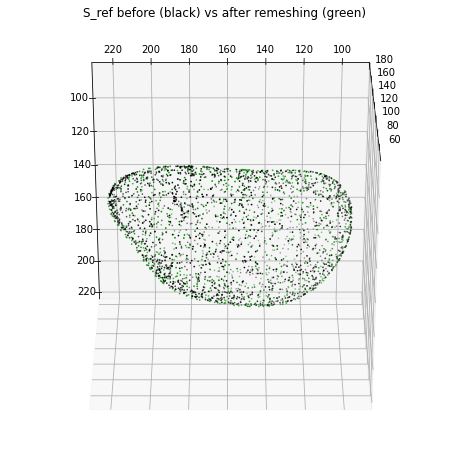

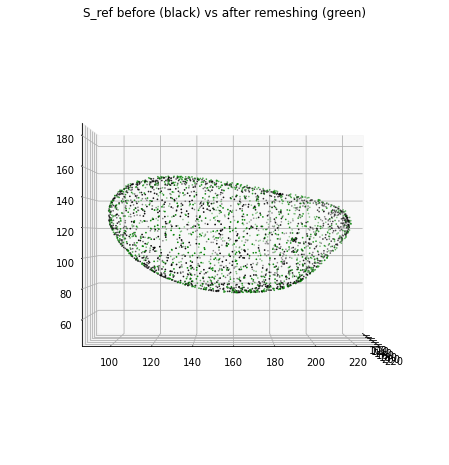

In [10]:
import unwrap3D.Visualisation.plotting as plotting # we import this so we can make x,y,z axes be plotted in equal proportions. 
import pylab as plt 

sampling = 100 # plot every just so its not fully dense in the plot so we don't see anything!

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S_ref before (black) vs after remeshing (green)')
# plotting the before
ax.scatter(cMCF_Sref.vertices[::sampling,2], 
           cMCF_Sref.vertices[::sampling,1],
           cMCF_Sref.vertices[::sampling,0], 
           s=0.5, 
           c='k')
# plotting the after
ax.scatter(cMCF_Sref_remesh.vertices[::sampling,2], 
           cMCF_Sref_remesh.vertices[::sampling,1],
           cMCF_Sref_remesh.vertices[::sampling,0], 
           s=0.5, 
           c='g')
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S_ref before (black) vs after remeshing (green)')
# plotting the before
ax.scatter(cMCF_Sref.vertices[::sampling,2], 
           cMCF_Sref.vertices[::sampling,1],
           cMCF_Sref.vertices[::sampling,0], 
           s=0.5, 
           c='k')
# plotting the after
ax.scatter(cMCF_Sref_remesh.vertices[::sampling,2], 
           cMCF_Sref_remesh.vertices[::sampling,1],
           cMCF_Sref_remesh.vertices[::sampling,0], 
           s=0.5, 
           c='g')
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

In [11]:
import igl 
# measure the geometric differences

# 1. mean squared error or Chamfer distance
mse = meshtools.chamfer_distance_point_cloud(cMCF_Sref.vertices, cMCF_Sref_remesh.vertices)
print('mean squared error: ', mse) # in terms of pixels 

# 3. diff surface area
diff_A = meshtools.diff_area_trimesh_trimesh(cMCF_Sref, cMCF_Sref_remesh)
fraction_A = diff_A / (np.nansum(igl.doublearea(cMCF_Sref.vertices, cMCF_Sref.faces) /2.))
print('fraction total surface area change: ', fraction_A) 


mean squared error:  1.3617656
fraction total surface area change:  -0.026104709135602415


### Mapping scalar and vectorial quantities to the remeshed $S_{ref}(x,y,z)$

Since $S_{ref}(x,y,z)$ is a smooth and star-convex shape we can now do mesh matching to put the cMCF and remeshed $S_{ref}(x,y,z)$ meshes into 1-1 correspondence. Since cMCF is bijective to the original surface, $S(x,y,z)$ we can also transfer the original surface onto the remeshed $S_{ref}(x,y,z)$ like any other signal. 


In [ ]:
"""
Do mesh matching to establish correspondence between S_ref before and after remesh.
"""
match_params = meshtools.match_and_interpolate_uv_surface_to_mesh(cMCF_Sref_remesh.vertices, # the mesh to map to (target) 
                                                                   cMCF_Sref, # the mesh mapping from (source)
                                                                   match_method='cross')

In [ ]:
"""
# Given the matching we can reinterpolate any quantity using barycentric interpolation.
"""
# Example 1: Reinterpolating the surface mean curvature of S(x,y,z) 

# we can't interpolate colors, therefore we need to load in previously computed surface curvature values.
curvature_stats_file = os.path.join(cell_surface_folder, 
                                    '%s_surface_curvature_intensity_stats' %(basefname)) 
surf_H = np.squeeze(spio.loadmat(curvature_stats_file)["surf_H"].copy())
remesh_S_ref_H = meshtools.mesh_vertex_interpolate_scalar(cMCF_Sref, 
                                                              match_params[0], 
                                                              match_params[1], 
                                                              surf_H[:,None])[:,0]
remesh_S_ref_H_color = vol_colors.get_colors(remesh_S_ref_H/.104, 
                                             colormap=cm.Spectral_r, 
                                             vmin=-1, 
                                             vmax=1)

# we now add this color to the remeshed S_ref
cMCF_Sref_remesh.visual.vertex_colors = np.uint8(255*remesh_S_ref_kappa_color[:,:3])
tmp = cMCF_Sref_remesh.export(os.path.join(savefolder, 
                                     'unwrap_cMCF_Sref_mesh_H_color.obj'))

# we will also save this remapped curvature value as we need it for all downstream visualizations !
spio.savemat(os.path.join(savefolder,
                         'unwrap_cMCF_remapped_surf_H.mat'), 
                        {'surf_H' : remesh_S_ref_H})


In [ ]:
# Example 2: Reinterpolating the coordinates of S(x,y,z) onto the remeshed S_ref(x,y,z) treating it as scalar signals. 

# load the input mesh and map its coordinates as a signal to remeshed S_ref(x,y,z)
remesh_S_ref_input_xyz = meshtools.mesh_vertex_interpolate_scalar(cMCF_Sref, 
                                                                   match_params[0], 
                                                                   match_params[1], 
                                                                   mesh.vertices)

print(remesh_S_ref_input_xyz.shape)


# Visualize the colocalization of points. The original mesh will be quasi-conformally mapped.
sampling = 20

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S(x,y,z) (black) and mapped to remeshed S_ref(x,y,z) (green)')
# plotting the before
ax.scatter(mesh.vertices[::sampling,2], 
           mesh.vertices[::sampling,1],
           mesh.vertices[::sampling,0], 
           s=1, 
           c='k')
# plotting the after
ax.scatter(remesh_S_ref_input_xyz[::sampling,2], 
           remesh_S_ref_input_xyz[::sampling,1],
           remesh_S_ref_input_xyz[::sampling,0], 
           s=1, 
           c='g')
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

cMCF_Sref_input_remesh = cMCF_Sref_remesh.copy()
cMCF_Sref_input_remesh.vertices = remesh_S_ref_input_xyz.copy()
tmp = cMCF_Sref_input_remesh.export(os.path.join(savefolder, 
                                             'remapped_input_surface_onto_cMCF_Sref_mesh_H_color.obj'))

## We now proceed to step 2 notebook to run quasi-conformal spherical parameterization of the genus-0 reference shape ...